# Supervised CARE Training

Here we use CARE training using noisy images as input and averaged noisy images as target.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import os
sys.path.append('../')
from unet.model import UNet
from pn2v import utils
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread

## Environment Variables and Directory Structure

In [2]:
STEPS=int(os.getenv('STEPS',5))
BATCH_SIZE = int(os.getenv('BATCHSIZE', 1))
EPOCHS = int(os.getenv('EPOCHS', 10))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR='/opt/dkube/input'
if not os.path.exists('/opt/dkube/output'):
    os.makedirs('/opt/dkube/output')
MODEL_DIR='/opt/dkube/output'

### Load Data

In [3]:
path=DATA_DIR+'/20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif'
fileName='20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif'
dataName='convallaria' # This will be used to name the "care" model

#### Noisy Data (Input to network)

In [4]:
data=imread(path)
nameModel=dataName+'_care'

#### Ground truth  Data (Target of Network)

In [5]:
dataGT = np.mean(data, axis=0)[np.newaxis,...,np.newaxis]

In [6]:
data=data[...,np.newaxis]
dataGT = np.repeat(dataGT, 100, axis=0)

print("Shape of Raw Noisy Image is ", data.shape, "; Shape of Target Image is ", dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
# Add the target image as a second channel to `data`
print("Shape of `data` is ", data.shape)

Shape of Raw Noisy Image is  (100, 1024, 1024, 1) ; Shape of Target Image is  (100, 1024, 1024, 1)
Shape of `data` is  (100, 1024, 1024, 2)


## Split Training and Validation data

In [7]:
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

## Visualising Raw Data

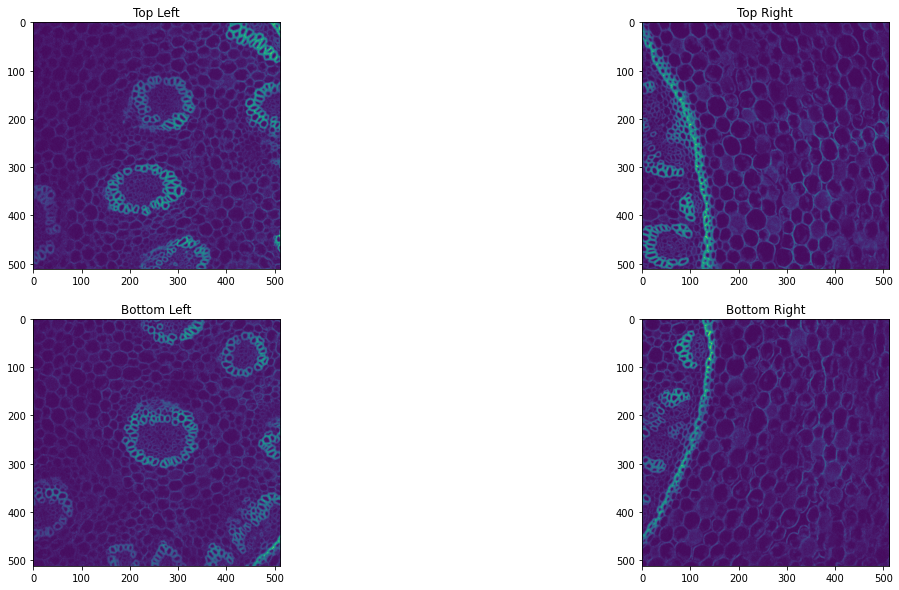

In [8]:
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
plt.imshow(data[0,:512,:512,0])
plt.title('Top Left')

plt.subplot(2,2,2)
plt.imshow(data[0,:512,512:,0])
plt.title('Top Right')

plt.subplot(2,2,3)
plt.imshow(data[0,512:,:512,0])
plt.title('Bottom Left')

plt.subplot(2,2,4)
plt.imshow(data[0,512:,512:,0])
plt.title('Bottom Right')
plt.show()

# We now crop away the top-left portion of the data since this portion will be used later for testing
data=np.concatenate( (data[:,512:,512:,:], data[:,:512,512:,:], data[:,512:,:512,:])  )

### Create the Network and Train it
This can take a while. Ensure that `supervised` = `True`.

In [9]:
net = UNet(1, depth=3)
trainHist, valHist = training.trainNetwork(net=net,trainData=my_train_data, valData=my_val_data,
                                           postfix=nameModel, directory=MODEL_DIR, noiseModel=None,numOfEpochs= EPOCHS, stepsPerEpoch=STEPS, 
                                           device=device, virtualBatchSize=20, batchSize=BATCH_SIZE, learningRate=1e-3, supervised=True)



Epoch 0 finished      
avg. loss: 0.2131086677312851+-(2SEM)0.038547564006440244      
Epoch 1 finished      
avg. loss: 0.14926399048417807+-(2SEM)0.06976917911758465      
Epoch 2 finished      
avg. loss: 0.07977780476212501+-(2SEM)0.024824521855272768      
Epoch 3 finished      
avg. loss: 0.05478815957903862+-(2SEM)0.018379351008772228      
Epoch 4 finished      
avg. loss: 0.06649850327521563+-(2SEM)0.01756877490159024      
Epoch 5 finished      
avg. loss: 0.04659879058599472+-(2SEM)0.01488272213153741      
Epoch 6 finished      
avg. loss: 0.03533884924836457+-(2SEM)0.008448245427666699      
Epoch 7 finished      
avg. loss: 0.028742730268277228+-(2SEM)0.009587551504530226      
Epoch 8 finished      
avg. loss: 0.02699498231522739+-(2SEM)0.011562631318302482      
Epoch 9 finished      
avg. loss: 0.023967581079341473+-(2SEM)0.007709102774713393      
Finished Training      


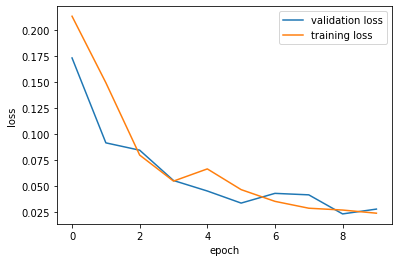

In [10]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()